### Parameter tuning in XGBoost using Gridsearch CV on normalized exoplanet search data.

Applying the Fast Fourier Transformation allows the signal allows it to be broken down to its visible frequencies. Plotting both these allows us to see the patterns present in the flux measurements (see below).

With the Fourier Transformation the first peak is the overall indicator of the frequency of the series. Subsequent harmonics (peaks) indicate the presence of an exoplanet.

GridsearchCV will be applied accross 6 classifiers to determine the best hyperparameters.

Imports

In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage 
import xgboost as xg
from imblearn.over_sampling import SMOTE #For imbalanced datasets
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline, Pipeline

Import pre-split data and set up train and test

In [368]:
train = pd.read_csv('exoTrain.csv')
test = pd.read_csv('exoTest.csv')

Change the labels from 2 & 1 to 1 and 0

In [369]:
train['LABEL'] = train['LABEL']-1
test['LABEL'] = test['LABEL']-1

Split off the target labels

In [370]:
X_train = train.drop('LABEL', axis=1)
y_train = train.LABEL
X_test = test.drop('LABEL', axis=1)
y_test = test.LABEL

Define normalize function and apply to train and test dataset

In [371]:
def normal(X):
    Y= (X-np.mean(X))/(np.max(X)-np.min(X))
    return Y

In [280]:
train_norm = train.drop('LABEL', axis=1)
train_norm = train_norm.apply(normal,axis=1)
train_norm = pd.concat([y_train,train_norm],axis=1)
train_norm.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,0.053834,0.047391,0.006510,-0.023699,-0.031772,-0.086410,-0.093128,-0.068161,-0.057650,...,-0.056482,-0.071934,-0.071934,0.009738,0.024779,0.052993,0.018843,0.033024,-0.003127,-0.031759
1,1,-0.050411,-0.042317,-0.081922,-0.052351,-0.115212,-0.104794,-0.126816,-0.124861,-0.122681,...,0.006648,-0.039721,-0.039721,-0.027988,0.004116,0.013124,-0.006847,0.022260,0.037550,0.043849
2,1,0.243983,0.245509,0.235186,0.227365,0.208538,0.212981,0.212283,0.222467,0.199285,...,-0.037161,0.002382,0.002382,-0.017715,-0.013523,-0.001456,-0.009299,-0.017259,-0.036384,-0.048782
3,1,0.518501,0.551177,0.480659,0.474051,0.504754,0.496863,0.511941,0.494687,0.496425,...,0.016215,0.001435,0.001435,0.054324,0.038636,-0.012562,-0.006456,-0.019827,-0.019889,0.029163
4,1,-0.399904,-0.401872,-0.404199,-0.395473,-0.381734,-0.373293,-0.360070,-0.368986,-0.356861,...,-0.212262,-0.141752,-0.141752,-0.125499,-0.157156,-0.155246,-0.141038,-0.135528,-0.145458,-0.181590


In [372]:
X_train_norm= X_train.apply(normal,axis=1)
X_test_norm= X_test.apply(normal,axis=1)

### Plotting out the light flux shows a pattern of dips. 
#### If there are 3 or more dips with the same spacing that makes an exoplanet transit likely. 
#### These were taken over an 80 day period every 30 mins.

Below are two examples of Exoplanets dimming the light from stars in a repeated pattern:

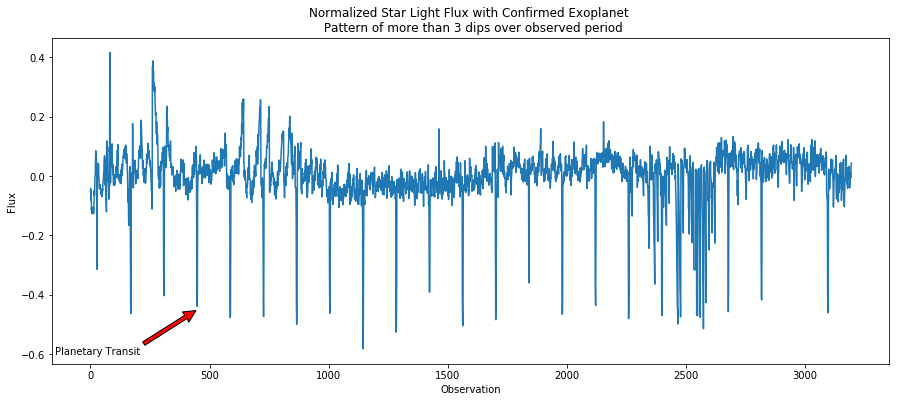

In [32]:
Y = X_train_norm.iloc[1]
X = np.arange(len(Y)) 

plt.figure(figsize=(15,6))
plt.annotate('Planetary Transit', xy=(450, -.45), xytext=(-150, -.6),arrowprops=dict(facecolor='red', shrink=0.03),)
plt.ylabel('Flux')
plt.xlabel('Observation')
plt.title('Normalized Star Light Flux with Confirmed Exoplanet \n Pattern of more than 3 dips over observed period')
plt.plot(X, Y)

plt.show()


The above plot has 23 transits, which equates to an exoplanet with an orbital period of 3-4 days. 

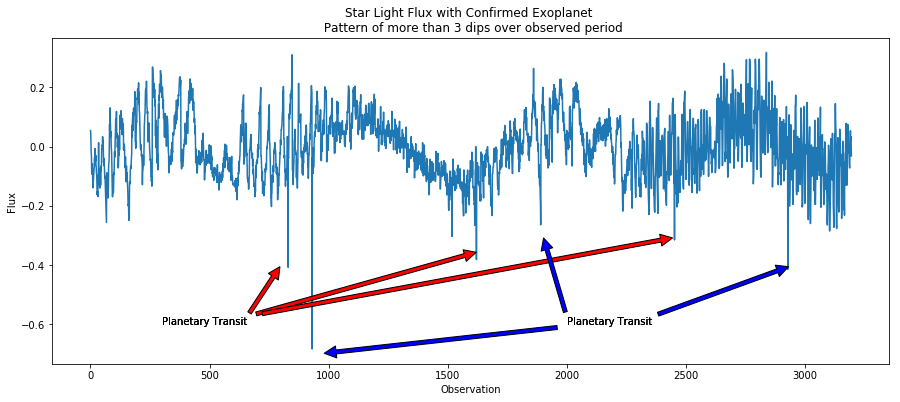

In [37]:

Y = X_train_norm.iloc[0]
X = np.arange(len(Y)) 
plt.figure(figsize=(15,6))
plt.annotate('Planetary Transit', xy=(800, -.4), xytext=(300, -.6),arrowprops=dict(facecolor='red', shrink=0.03),)
plt.annotate('Planetary Transit', xy=(1650, -.35), xytext=(300, -.6),arrowprops=dict(facecolor='red', shrink=0.03),)
plt.annotate('Planetary Transit', xy=(2500, -.3), xytext=(300, -.6),arrowprops=dict(facecolor='red', shrink=0.03),)

plt.annotate('Planetary Transit', xy=(950, -.7), xytext=(2000, -.6),arrowprops=dict(facecolor='blue', shrink=0.03),)
plt.annotate('Planetary Transit', xy=(1900, -.3), xytext=(2000, -.6),arrowprops=dict(facecolor='blue', shrink=0.03),)
plt.annotate('Planetary Transit', xy=(2950, -.4), xytext=(2000, -.6),arrowprops=dict(facecolor='blue', shrink=0.03),)

plt.ylabel('Flux')
plt.xlabel('Observation')
plt.title('Star Light Flux with Confirmed Exoplanet \n Pattern of more than 3 dips over observed period')
plt.plot(X, Y)
plt.show()

The above plot has 3 similar transits (red arrows), which could be an exoplanet with an orbital period of about 26 days. Note also there is a second pattern with a repeated harmonic(blue arrows). This system may have 2 exoplanets transiting.

#### And here are two examples where there are no discernable patterns of light dimming

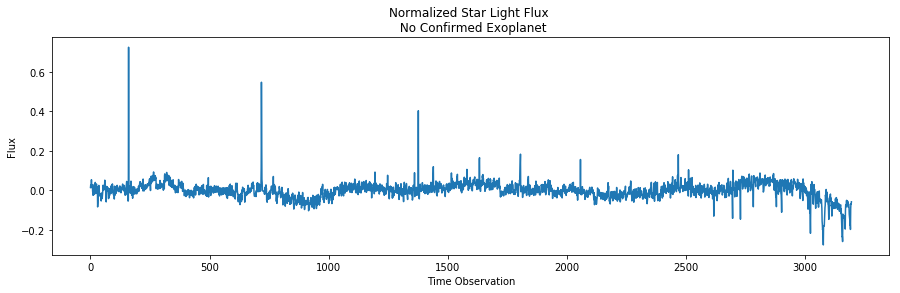

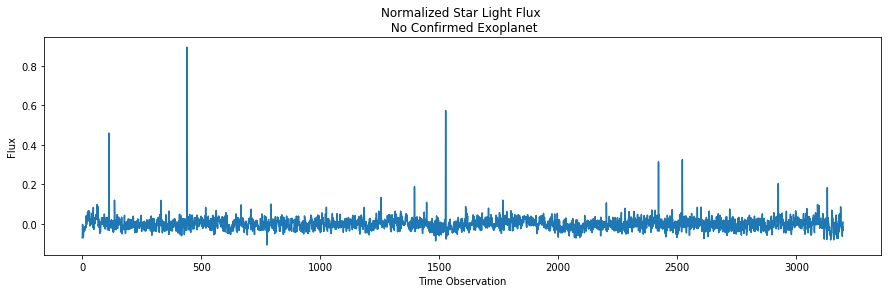

In [39]:
for i in [5000,5003]:
    Y = X_train_norm.iloc[i]
    X = np.arange(len(Y)) 
    plt.figure(figsize=(15,4))
    plt.ylabel('Flux')
    plt.xlabel('Time Observation')
    plt.title('Normalized Star Light Flux \n No Confirmed Exoplanet')
    plt.plot(X, Y)
    plt.show()


In [43]:
train_n = train.drop('LABEL',axis=1)
train_n= train_n.apply(normal,axis=1)
train_n['mean'] = train_n.mean(axis=1)
train_n['std'] = train_n.std(axis=1)
train_n['min'] = train_n.min(axis=1)


In [54]:
trainmerged = pd.concat([y_train,train_n],axis=1)

In [66]:
exo = trainmerged[trainmerged['LABEL']==1][['LABEL','mean','std','min']]
exo_no = trainmerged[trainmerged['LABEL']==0][['LABEL','mean','std','min']]

In [65]:
exo.head()

,LABEL,mean,std,min
0,1,2.131588e-17,0.103119,-0.682690
1,1,1.659301e-17,0.096170,-0.583164
2,1,-3.582961e-17,0.131113,-0.410850
3,1,-2.597147e-17,0.161614,-0.412969
4,1,3.177523e-18,0.148937,-0.656592


In [281]:
exo_no.head()

,LABEL,mean,std,min
37,0,3.478129e-18,0.035354,-0.701597
38,0,2.403761e-18,0.053797,-0.491181
39,0,7.778862e-19,0.031662,-0.258478
40,0,2.940945e-18,0.079806,-0.169188
41,0,2.028513e-19,0.016849,-0.061228


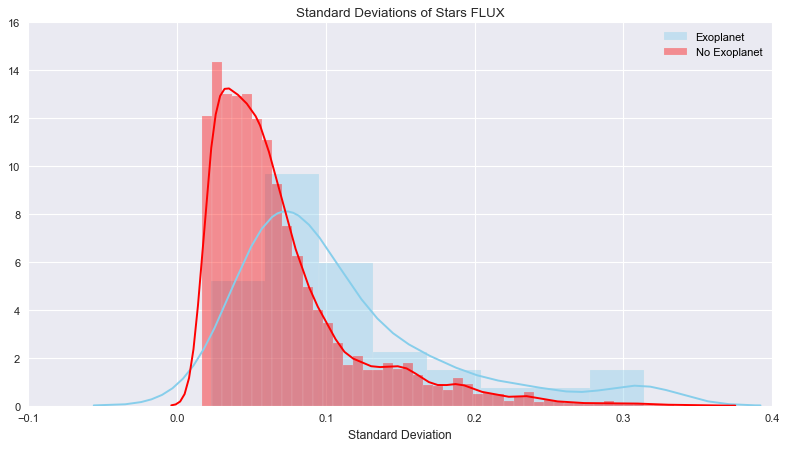

In [348]:
import seaborn as sns
sns.set()

x1 = exo['std']
x0 = exo_no['std']
plt.figure(figsize=(12,6))
sns.distplot( x1 , color="skyblue", label="Exoplanet")
sns.distplot( x0 , color="red", label="No Exoplanet")
plt.title('Standard Deviations of Stars FLUX')
plt.xlabel('Standard Deviation')
plt.ylim(0,16)
legend = plt.legend()

plt.setp(legend.get_texts(), color='k')
plt.title('Standard Deviations of Stars FLUX')
plt.show()

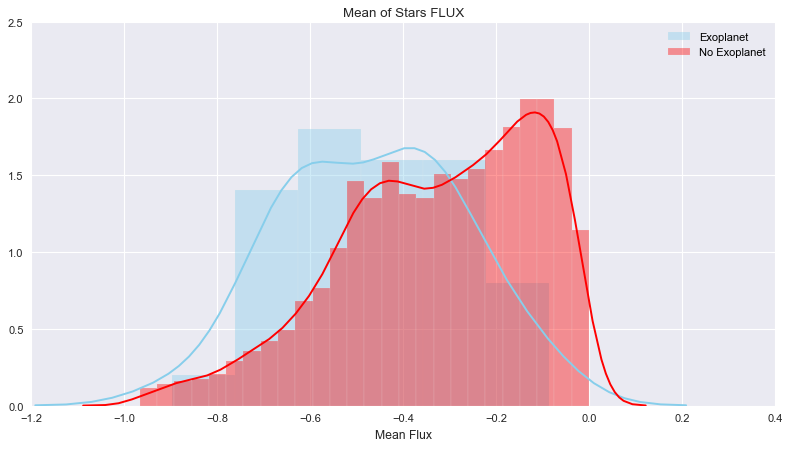

In [350]:
sns.set()


x1 = exo['min']
x0 = exo_no['min']
plt.figure(figsize=(12,6))
sns.distplot( x1 , color="skyblue", label="Exoplanet")
sns.distplot( x0 , color="red", label="No Exoplanet")
plt.xlabel('Mean Flux')
plt.ylim(0,2.5)
legend = plt.legend()
plt.setp(legend.get_texts(), color='k')
plt.title('Mean of Stars FLUX')
plt.show()

This plot shows the majority of non exoplanet detected stars have a lower standard deviation and minimum flux.

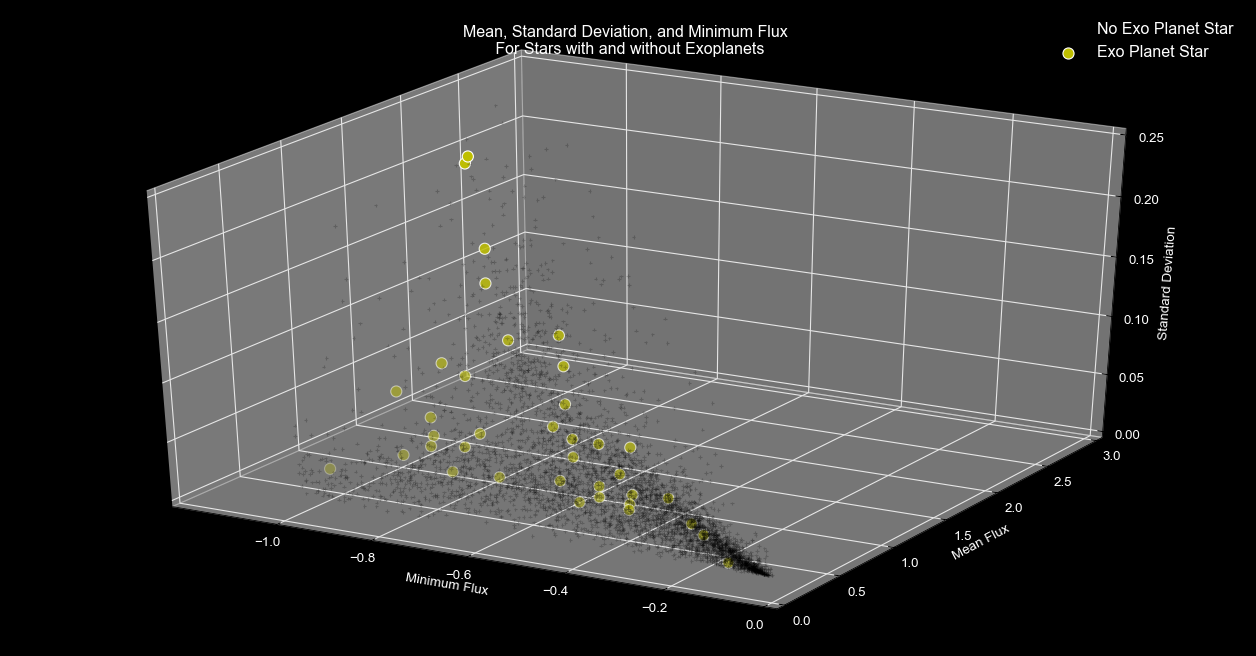

In [150]:
plt.style.use("dark_background")
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')


ys = exo['mean']
zs = exo['std']
xs = exo['min']

yt = exo_no['mean']
zt = exo_no['std']
xt = exo_no['min']

ax.scatter(xt, yt, zt, c='k', marker='+', alpha=.2, s = 10)
ax.scatter(xs, ys, zs, c='y', marker='o', s=100)

ax.set_title('Mean, Standard Deviation, and Minimum Flux \n For Stars with and without Exoplanets')
ax.set_xlabel('Minimum Flux')
ax.set_ylabel('Mean Flux')
ax.set_zlabel('Standard Deviation')
ax.set_ylim(0,3)
ax.set_xlim(-1.2,0)
ax.set_zlim(0,0.25)

ax.legend(["No Exo Planet Star","Exo Planet Star" ])

plt.show()

---


---

### Fast Fourier Transform

Using the fft function (Fast Fourier Transformation) to clean up the overlaid signals.

In [373]:
def fourier(X):
    Y = scipy.fft(X, n=X.size)
    return np.abs(Y)

In [374]:
X_train_FFT1 = X_train_norm.apply(fourier,axis=1)
X_test_FFT1 = X_test_norm.apply(fourier,axis=1)

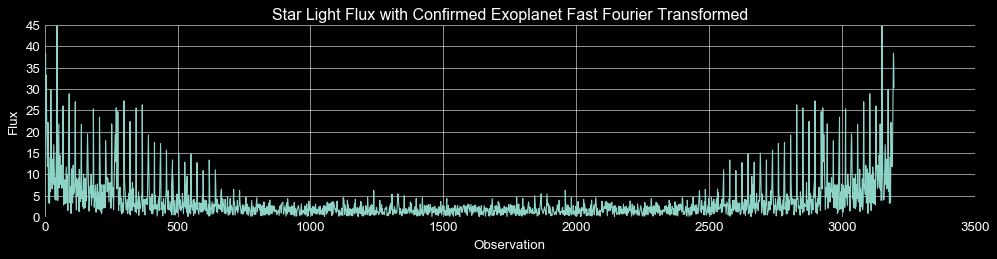

In [132]:
Y = X_train_FFT1.iloc[1]
X = np.arange(len(Y)) 
plt.figure(figsize=(15,3))
plt.ylabel('Flux')
plt.xlabel('Observation')
plt.title('Star Light Flux with Confirmed Exoplanet Fast Fourier Transformed')
plt.plot(X, Y)
plt.show()

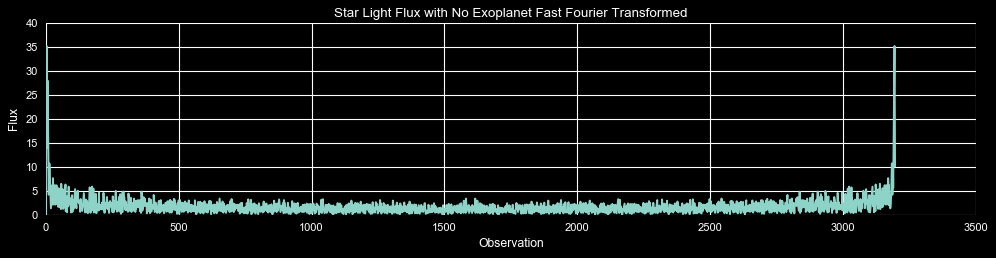

In [376]:
plt.style.use("dark_background")
Y = X_train_FFT1.iloc[5000]
X = np.arange(len(Y)) 
plt.figure(figsize=(15,3))
plt.ylabel('Flux')
plt.xlabel('Observation')
plt.title('Star Light Flux with No Exoplanet Fast Fourier Transformed')
plt.plot(X, Y)
plt.show()

With this symmetry we can reduce the number of features(observations) by half

In [30]:
len(X_train.iloc[1])/2

1598.5

Drop the first 1600 (half) features

In [152]:
X_train = X_train.drop(X_train.columns[1600:], axis=1)
X_test = X_test.drop(X_test.columns[1600:], axis=1)

### Fast Fourier Transform a second time on the reduced dataset


Apply the normalizing function

In [153]:
X_train= X_train.apply(normal,axis=1)
X_test= X_test.apply(normal,axis=1)

In [156]:
X_train_FFT1 = X_train.apply(fourier,axis=1)
X_test_FFT1 = X_test.apply(fourier,axis=1)

Reduce the data set again since FFT created symmetry

In [158]:
X_train_FFT2 = X_train_FFT1.drop(X_train.columns[800:], axis=1)
X_test_FFT2 = X_test_FFT1.drop(X_test.columns[800:], axis=1)

What does the new flux observation data now look like?

#### The first readings from the FFT is the base frequency, the subsequet peaks that are repeated are the harmonics of transiting exoplanets

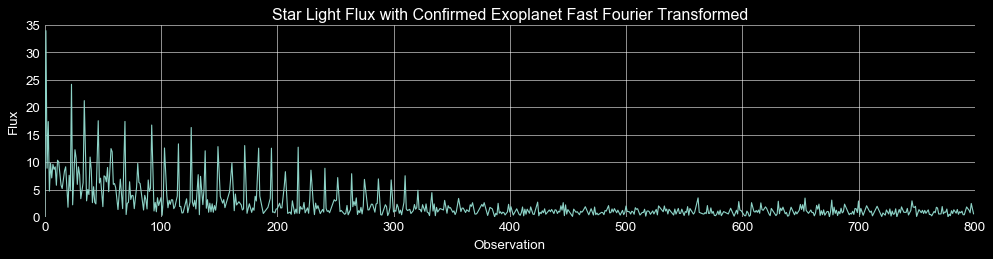

In [159]:
Y = X_train_FFT2.iloc[1]
X = np.arange(len(Y)) 
plt.figure(figsize=(15,3))
plt.ylabel('Flux')
plt.xlabel('Observation')
plt.title('Star Light Flux with Confirmed Exoplanet Fast Fourier Transformed')
plt.plot(X, Y)
plt.show()

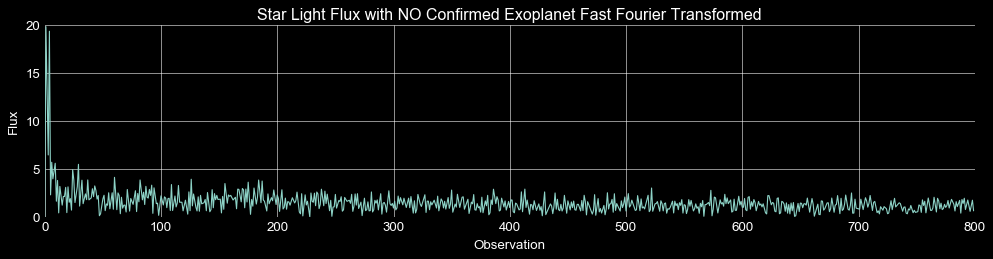

In [168]:
Y = X_train_FFT2.iloc[5000]
X = np.arange(len(Y)) 
plt.figure(figsize=(15,3))
plt.ylabel('Flux')
plt.xlabel('Observation')
plt.title('Star Light Flux with NO Confirmed Exoplanet Fast Fourier Transformed')
plt.plot(X, Y)
plt.show()

Drop the lower observations as outliers/base wave length


In [169]:
X_train_FFT2_1 = X_train_FFT2.drop(X_train_FFT2.columns[1:50], axis=1)
X_test_FFT2_1 = X_test_FFT2.drop(X_test_FFT2.columns[1:50], axis=1)

Notice the clear peaks and the harmonic repetition:

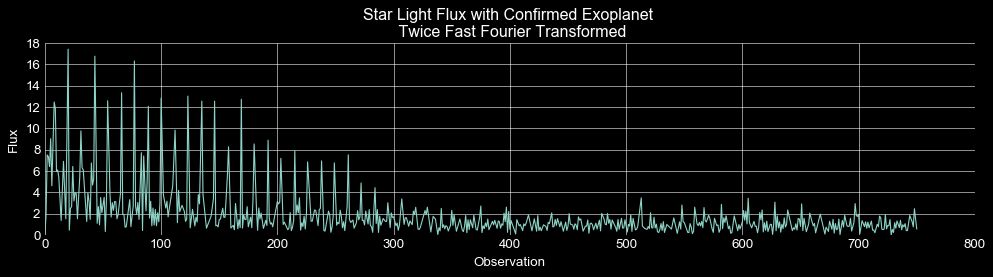

In [249]:
Y = X_train_FFT2_1.iloc[1]
X = np.arange(len(Y)) 
plt.figure(figsize=(15,3))
plt.ylabel('Flux')
plt.xlabel('Observation')
plt.title('Star Light Flux with Confirmed Exoplanet \n Twice Fast Fourier Transformed')
plt.plot(X, Y)
plt.show()

Notice the clear peaks and the harmonic repetition:

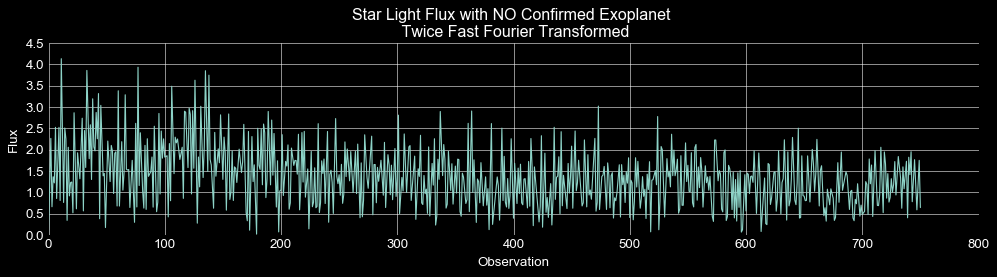

In [251]:
Y = X_train_FFT2_1.iloc[5000]
X = np.arange(len(Y)) 
plt.figure(figsize=(15,3))
plt.ylabel('Flux')
plt.xlabel('Observation')
plt.title('Star Light Flux with NO Confirmed Exoplanet \n Twice Fast Fourier Transformed')
plt.plot(X, Y)
plt.show()

---

#### With the dataset so strongly imbalanced we need to instatiate and execute oversampling using SMOTE (Synthetic Minority Oversampling Technique). This will prevent overfitting and poor accuracy.

Instatiate SMOTE to assist with the imbalanced dataset.


In [189]:
sm = SMOTE(ratio = 'auto', random_state=123)

Normalize the data again and convert to matrix for the classifiers to operate on.

In [198]:
X_train_norm= X_train_FFT2_1.apply(normal,axis=1)
X_test_norm= X_test_FFT2_1.apply(normal,axis=1)

In [199]:
X_train= X_train_norm.as_matrix()
X_test= X_test_norm.as_matrix()

Define the estimator selection to pipeline the GridSearchCV function

In [201]:
class EstimatorSelectionHelper:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            sm = SMOTE(ratio = 'auto', random_state=123)
            model = self.models[key]
            params = self.params[key]
            pipeline = Pipeline([('sm',sm), ('model',model)]) #create a PIPELINE to apply SMOTE
            kf = StratifiedKFold(n_splits=10)
            gs = GridSearchCV(pipeline, params, cv=cv, n_jobs=n_jobs, 
                              verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs    
    
    def score_summary(self, sort_by='min_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': std(scores)
            }
            return pd.Series({**params,**d}) 
                      
        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                     for k in self.keys
                     for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False) 
        
        columns = ['estimator', 'min_score', 'max_score','std_score'] 
        columns = columns + [c for c in df.columns if c not in columns]
        
        return df[columns]

Define the 6 models and their hyperparamters range that will run through the Gridsearch

- Random Forest
- AdaBoost
- XGBoost
- Decision Tree
- K Neighbors
- Bagging

In [263]:
models1 = { 
    
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'XGBClassifier': xg.XGBClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'KNClassifier': KNeighborsClassifier(),
    'BaggingClassifer': BaggingClassifier(),

}

params1 = { 
    'RandomForestClassifier': { "model__n_estimators": [10, 18, 22, 30],
              "model__max_depth": [3, 5],
              "model__min_samples_split": [15, 20],
              "model__min_samples_leaf": [5, 10, 20], },
    
    'AdaBoostClassifier':  { "model__n_estimators": [10, 18, 22, 30],
                            },
              
    'XGBClassifier': { 'model__n_estimators': [1000],
                      'model__learning_rate': [1.0],
                      'model__max_depth':range(3,10,2),
                      'model__min_child_weight':range(1,6,2) 
                     },
    
    'DecisionTree': {'model__min_samples_split': [7, 15, 20],
                    },
    
    'KNClassifier': {'model__n_neighbors':[3,5,7]
                    },
    
    'BaggingClassifer': {'model__n_estimators':[6,9,12],},

}

Set the f1 scorer 

In [261]:
f1_scorer = make_scorer(f1_score, pos_label=1)

Set the recall scorer 

In [266]:
recall_scorer = make_scorer(recall_score, pos_label=1)

Run the helper function with the models, parameters and scoring criteria

In [267]:
helper = EstimatorSelectionHelper(models1, params1)
helper.fit(X_train, y_train, scoring=recall_scorer, n_jobs=-1)

Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   49.5s finished


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   43.0s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   50.9s finished


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  7.5min finished


Running GridSearchCV for DecisionTree.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   13.2s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   21.8s finished


Running GridSearchCV for KNClassifier.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  2.1min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.1min finished


Running GridSearchCV for BaggingClassifer.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   40.8s remaining:   51.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.1min finished


List out the summary for Recall Score

In [356]:
helper.score_summary(sort_by='max_score').head() #Recall score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_

,estimator,min_score,max_score,mean_score,model__learning_rate,model__max_depth,model__min_child_weight,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__n_neighbors
69,KNClassifier,0.538462,0.833333,0.707265,NaN,NaN,NaN,NaN,NaN,NaN,7
68,KNClassifier,0.461538,0.833333,0.681624,NaN,NaN,NaN,NaN,NaN,NaN,5
67,KNClassifier,0.384615,0.75,0.600427,NaN,NaN,NaN,NaN,NaN,NaN,3
49,AdaBoostClassifier,0.153846,0.666667,0.384615,NaN,NaN,NaN,NaN,NaN,18,NaN
11,RandomForestClassifier,0.153846,0.666667,0.384615,NaN,3,NaN,10,15,30,NaN


The strongest mean sore was K Nearest - setting the parameters to n_neighbors = 7 

In [271]:
#Set the sampling
sm = SMOTE(ratio =1.0,random_state=123 )
model = KNeighborsClassifier(n_neighbors=7)

#fit the data through sampling then run the model
X_r, y_r = sm.fit_sample(X_train, y_train)
model.fit(X_r, y_r)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
recall_sc = recall_score(y_test, predictions,pos_label = 1)
f2_score = f1_score(y_test, predictions,pos_label = 1)
print("F1 score: %.2f%%" % (f2_score * 100.0))
print("Recall score: %.2f%%" % (recall_sc * 100.0))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


F1 score: 14.55%
Recall score: 80.00%


In [366]:
confusion_matrix(y_test, predictions)

array([[519,  46],
       [  1,   4]], dtype=int64)